In [1]:
import numpy as np

In [2]:
import pandas as pd 
import anndata as ad
import scanpy as sc

In [3]:
import screenpro as scp

In [4]:
import matplotlib.pyplot as plt

In [5]:
sc.settings.set_figure_params(dpi=150, frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

___
    
    Thu Nov 16 11:29:49 PST 2023
    
Tom 
> Are you able to extract phenotype scores from each screen replicate independently? The excel tables you provide are obviously an average of all replicates but I'd like to be able to plot bar graphs of phenotype scores for some genes that includes all three replicates to show the variability/error bars


In [36]:
help(scp.phenoScore.getScore)

Help on function getScore in module screenpro.phenoScore:

getScore(x, y, x_ctrl, y_ctrl, growth_rate, math, ave)
    Calculate phenotype score normalized by negative control and growth rate.
    Args:
        x (np.array): array of values
        y (np.array): array of values
        x_ctrl (np.array): array of values
        y_ctrl (np.array): array of values
        growth_rate (int): growth rate
        math (str): math to use for calculating score
        ave (str): average method
    Returns:
        np.array: array of scores



In [83]:
def get_replicate_score(screen,x_label, y_label):
    adata_ctrl = screen.adata[:,screen.adata.var.targetType.eq('negCtrl')].copy()

    results = {}
    
    for replicate in screen.adata.obs.replicate.unique():

        res = scp.phenoScore.getScore(
            x = screen.adata[screen.adata.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y = screen.adata[screen.adata.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            x_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            growth_rate=1,
            math = screen.math,
            ave = 'row'
        )
        
        results.update({f'replicate_{replicate}':res})
    
    
    out = pd.DataFrame(
        results,
        index = screen.adata.var.index
    )
    return out

___

In [13]:
help(screen.calculateDrugScreen)

Help on method calculateDrugScreen in module screenpro:

calculateDrugScreen(t0, untreated, treated, growth_rate, score_level) method of screenpro.ScreenPro instance
    Calculate gamma, rho, and tau phenotype scores for a drug screen dataset in a given `score_level`
    see this issue for discussion https://github.com/abearab/ScreenPro2/issues/15.
    Args:
        t0 (str): name of the untreated condition
        untreated (str): name of the untreated condition
        treated (str): name of the treated condition
        growth_rate (float): growth rate of the untreated condition
        score_level (str): name of the score level



# 

In [86]:
reps_results = {}

In [38]:
adata = ad.read_h5ad('results/adata_counts.h5ad.gz')
adata.obs['condition'] = adata.obs.treatment.replace('-','T0')
adata.obs = adata.obs[['cell line','condition','rep']].rename(columns={'rep':'replicate'})
adata.obs.index.name = None

adata.X = adata.layers['raw']
del adata.layers

In [28]:
target_df = adata.var.sort_values(by=['target','targetType'],ascending=True)[['target']]

In [64]:
adata = adata[:,target_df.index].copy()

## PRDX1_parent

In [104]:
adata_parent0 = adata[adata.obs['cell line'].eq('parent')].copy()

In [105]:
screen_parent0 = scp.ScreenPro(
    adata_parent0
)

In [106]:
adata_parent = adata_parent0[~adata_parent0.obs.replicate.eq(3)].copy()

In [107]:
screen_parent = scp.ScreenPro(
    adata_parent
)

In [108]:
screen_parent.adata.obs

,cell line,condition,replicate
i01,parent,T0,1
i02,parent,T0,2
i03,parent,vehicle,1
i04,parent,vehicle,2
i06,parent,DNAPKi,1
i07,parent,DNAPKi,2


In [109]:
screen_parent.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi', growth_rate=1, 
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [110]:
# screen_parent.phenotypes['compare_reps']

### 

In [111]:
reps_results['parent:DNAPKi_vs_vehicle'] = pd.concat({
    '':screen_parent.adata.var.target,
    # 'gamma':get_replicate_score(screen_parent,'T0', 'vehicle'),
    # 'tau':get_replicate_score(screen_parent,'T0', 'DNAPKi'),
    'rho':get_replicate_score(screen_parent0,'vehicle', 'DNAPKi')
},axis=1)

### gamma 

In [22]:
score = 'gamma'
cond1 = "T0"
cond2 = "vehicle"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [23]:
runPhenoScore(
    adata_parent,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0]
)

#### Save to results

In [24]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3720
resistance_hit        76
gene_non_hit       16275
non-targeting       1026
dtype: int64

#### volcano plots

In [25]:
df = results[screen_name].reset_index().copy()

In [26]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.867277610454432, 1.3923369823352967, 5.153281987091899)

In [27]:
%%R
source('scripts/plots.R')

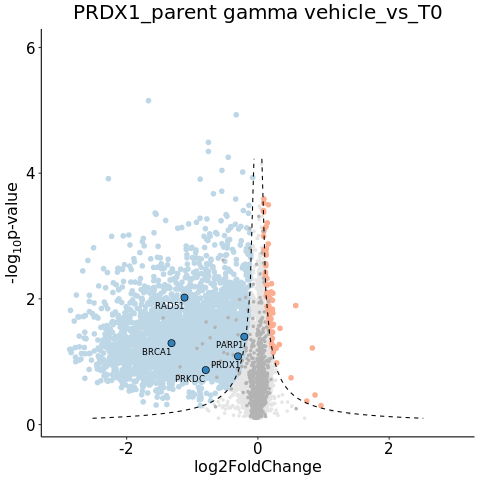

In [28]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### tau

In [29]:
score = 'tau'
cond1 = "T0"
cond2 = "DNAPKi"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [30]:
runPhenoScore(
    adata_parent,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
)

#### Save to results

In [31]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3704
resistance_hit        70
gene_non_hit       16297
non-targeting       1026
dtype: int64

#### volcano plots

In [32]:
df = results[screen_name].reset_index().copy()

In [33]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.92001204964309, 1.6245284537858926, 4.678425046287424)

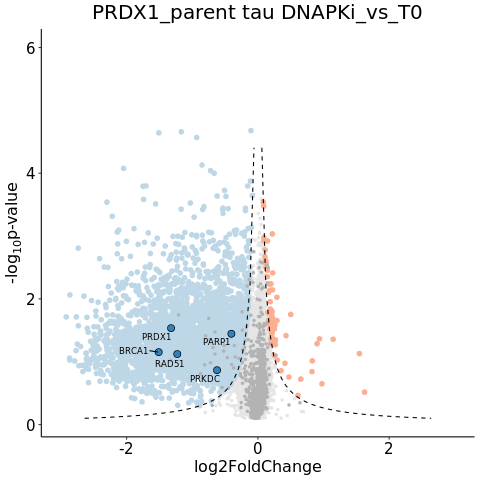

In [34]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### rho

In [35]:
score = 'rho'
cond1 = "vehicle"
cond2 = "DNAPKi"

screen_name = f'PRDX1_parent {score} {cond2}_vs_{cond1}'

In [36]:
runPhenoScore(
    adata_parent,cond1,cond2,n_reps=3,
    growth_rate=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_DNAPKi'].values[0]
    ])
)

#### Save to results

In [41]:
results[screen_name] = ann_score_df(
    adata_parent.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      874
resistance_hit       943
gene_non_hit       18254
non-targeting       1026
dtype: int64

#### volcano plots

In [42]:
df = results[screen_name].reset_index().copy()

In [43]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.7335990484022497, 2.872885617787636, 5.354735824724727)

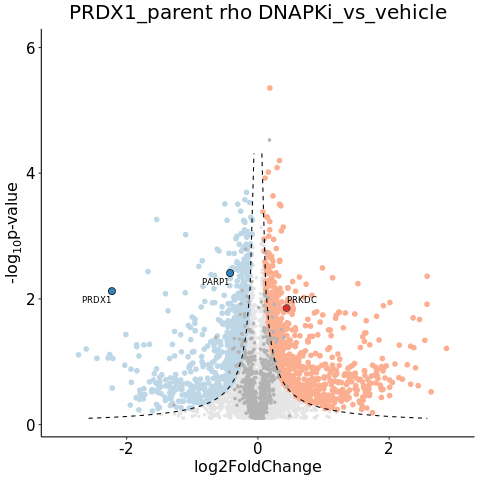

In [44]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRDX1", 
        # "RAD51", 
        "PARP1"
        # "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## PRDX1_KO

In [112]:
adata_KO_0 = adata[adata.obs['cell line'].eq('PRDX1KO')].copy()

In [113]:
screen_KO_0 = scp.ScreenPro(
    adata_KO_0
)

In [114]:
adata_KO = adata_KO_0[~adata_KO_0.obs.replicate.eq(3)].copy()

In [115]:
screen_KO = scp.ScreenPro(
    adata_KO
)

In [116]:
adata_KO.obs

,cell line,condition,replicate
i09,PRDX1KO,T0,1
i10,PRDX1KO,T0,2
i11,PRDX1KO,vehicle,1
i12,PRDX1KO,vehicle,2
i14,PRDX1KO,DNAPKi,1
i15,PRDX1KO,DNAPKi,2


In [118]:
screen_KO.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='DNAPKi', growth_rate=1, 
    score_level='compare_reps'
)

	vehicle vs T0
	DNAPKi vs T0
	DNAPKi vs vehicle


In [80]:
# screen_KO.phenotypes['compare_reps']

### 

In [119]:
reps_results['KO:DNAPKi_vs_vehicle'] = pd.concat({
    '':screen_parent.adata.var.target,
    # 'gamma':get_replicate_score(screen_parent,'T0', 'vehicle'),
    # 'tau':get_replicate_score(screen_parent,'T0', 'DNAPKi'),
    'rho':get_replicate_score(screen_KO_0,'vehicle', 'DNAPKi')
},axis=1)

In [123]:
pd.concat(reps_results,axis=1).to_excel('PRDX1_screen_replicate_phenotype_scores.xlsx')

### gamma

In [49]:
score = 'gamma'
cond1 = "T0"
cond2 = "vehicle"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [50]:
runPhenoScore(
    adata_KO,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
)

#### Save to results

In [51]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     3255
resistance_hit       122
gene_non_hit       16694
non-targeting       1026
dtype: int64

#### volcano plots

In [52]:
df = results[screen_name].reset_index().copy()

In [53]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-3.5926818888707266, 1.4796094855546478, 4.970620837389516)

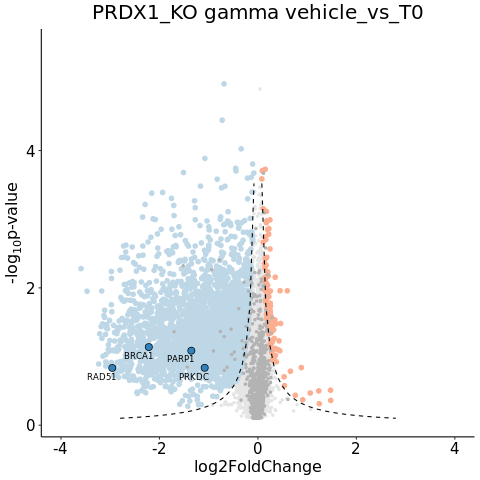

In [54]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-4,xlim_r=4, ylim=5.5,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### tau

In [55]:
score = 'tau'
cond1 = "T0"
cond2 = "DNAPKi"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [56]:
runPhenoScore(
    adata_KO,cond1,cond2,
    growth_rate=screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_DNAPKi'].values[0]
)

#### Save to results

In [57]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit     2642
resistance_hit       278
gene_non_hit       17151
non-targeting       1026
dtype: int64

#### volcano plots

In [58]:
df = results[screen_name].reset_index().copy()

In [59]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-13.623205446006606, 7.842597561995435, 5.28705668935465)

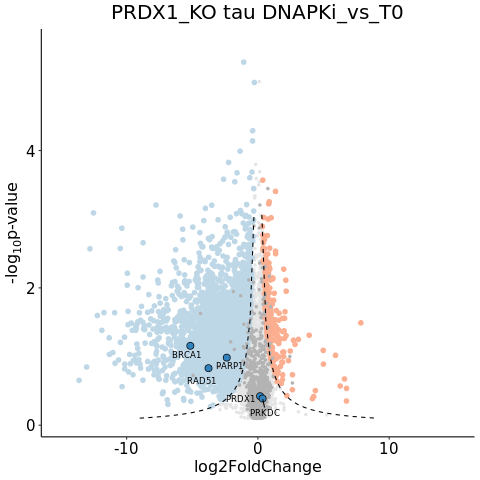

In [60]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-15,xlim_r=15, ylim=5.5,threshold=THRESHOLD) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

### rho

In [61]:
score = 'rho'
cond1 = "vehicle"
cond2 = "DNAPKi"

screen_name = f'PRDX1_KO {score} {cond2}_vs_{cond1}'

In [62]:
runPhenoScore(
    adata_KO,cond1,cond2,n_reps=3,
    growth_rate=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_DNAPKi'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
    ])   
)

#### Save to results

In [63]:
results[screen_name] = ann_score_df(
    adata_KO.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      271
resistance_hit      3051
gene_non_hit       16749
non-targeting       1026
dtype: int64

#### volcano plots

In [64]:
df = results[screen_name].reset_index().copy()

In [65]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.122151549680133, 4.740173687303975, 5.17247283805695)

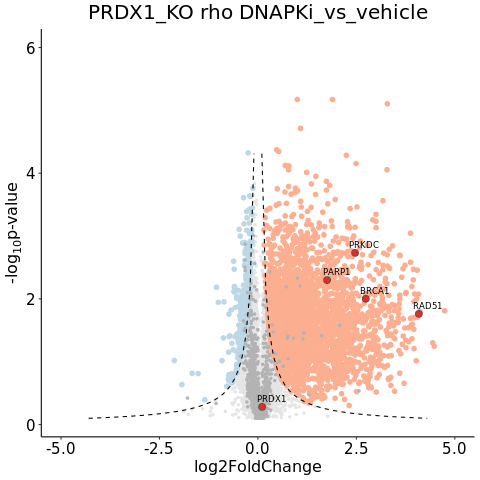

In [66]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-5,xlim_r=5, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "PRDX1", 
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## vehicle
    vehicle_PRDX1KO_vs_vehicle_parent

In [67]:
adata_vehicle = adata[adata.obs['condition'].eq('vehicle')].copy()

adata_vehicle.obs['condition'] = adata_vehicle.obs['cell line']

del adata_vehicle.obs['cell line']

In [68]:
adata_vehicle.obs

,condition,rep,size_factors
i03,parent,1,1.313857
i04,parent,2,1.182584
i05,parent,3,1.273702
i11,PRDX1KO,1,1.091873
i12,PRDX1KO,2,1.110228
i13,PRDX1KO,3,2.439991


### rho

In [69]:
score = 'rho'
cond1 = "parent"
cond2 = "PRDX1KO"

screen_name = f'vehicle {score} {cond2}_vs_{cond1}'

In [70]:
runPhenoScore(
    adata_vehicle,cond1,cond2,n_reps=3,
    growth_rate=np.mean([
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['parent_vehicle'].values[0],
        screengrowthsummary[screengrowthsummary.Day.eq(11)]['PRDX1ko_vehicle'].values[0]
    ])   

)

#### Save to results

In [71]:
results[screen_name] = ann_score_df(
    adata_vehicle.var[['target',f'condition_{cond2}_vs_{cond1}_delta',f'condition_{cond2}_vs_{cond1}_pvalue']], threshold=THRESHOLD
).loc[target_df.index,:].set_index('gene')

results[screen_name].groupby('label').size()

label
sensitivity_hit      841
resistance_hit      2704
gene_non_hit       16526
non-targeting       1026
dtype: int64

#### volcano plots

In [72]:
df = results[screen_name].reset_index().copy()

In [73]:
df.score.min(),df.score.max(), -np.log10(df.pvalue.min())

(-2.537471314962964, 2.4744426275359284, 5.039225010601307)

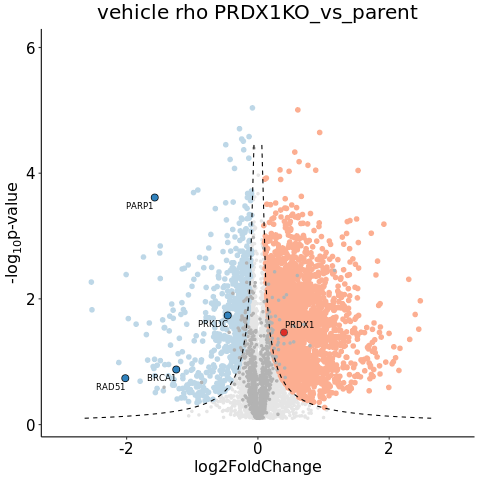

In [74]:
%%R -i df,screen_name,THRESHOLD

plot_volcano(df, xlim_l=-3,xlim_r=3, ylim=6,threshold=THRESHOLD) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRDX1"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRKDC",
        "RAD51", 
        "PARP1",
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

## Save results as a excel

In [75]:
data = pd.concat(results,axis=1)

In [76]:
set(data.columns.to_frame()[0].to_list())

{'PRDX1_KO gamma vehicle_vs_T0',
 'PRDX1_KO rho DNAPKi_vs_vehicle',
 'PRDX1_KO tau DNAPKi_vs_T0',
 'PRDX1_parent gamma vehicle_vs_T0',
 'PRDX1_parent rho DNAPKi_vs_vehicle',
 'PRDX1_parent tau DNAPKi_vs_T0',
 'vehicle rho PRDX1KO_vs_parent'}

In [77]:
data.to_excel('results/phenotype_scores.xlsx')

# 

## Plots

In [278]:
# screen.phenotypes['compare_reps']['tau:NAC_vs_T0']

In [279]:
almost_black = '#111111'

dark2 = ['#1b9e77',
         '#d95f02',
         '#7570b3',
         '#e7298a',
         '#66a61e',
         '#e6ab02',
         '#a6761d',
         '#666666']

### replicate scatter plots

In [280]:
def draw_scatter(adata, x, y, title, ax):
    bdata = adata[[x, y],:].copy()
    
    bdata.obs.index = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    x_lab, y_lab = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    
    sc.pp.log1p(bdata)
    sc.pl.scatter(
        bdata,
        x_lab, y_lab,
        legend_fontsize='xx-large',
        palette=[almost_black,'#BFBFBF'],
        color='targetType',
        title=title,
        size=5,
        show=False,
        ax = ax
    )
    ax.set_ylim(-1,11)
    ax.set_xlim(-1,11)
    ax.tick_params(axis='both', labelsize=10)
    ax.get_legend().remove()
    
    ax.grid(False)

In [559]:
screen.adata.obs

,condition,replicate,size_factors
TO_1_S1,T0,1,0.727538
TO_2_S2,T0,2,2.152822
TO_3_S3,T0,3,0.521350
TO_4_S4,vehicle,1,1.072814
TO_5_S5,vehicle,2,0.971792
TO_6_S6,vehicle,3,0.872361
TO_7_S7,NAC,1,1.224911
TO_8_S8,NAC,2,1.332865
TO_9_S9,NAC,3,0.775176


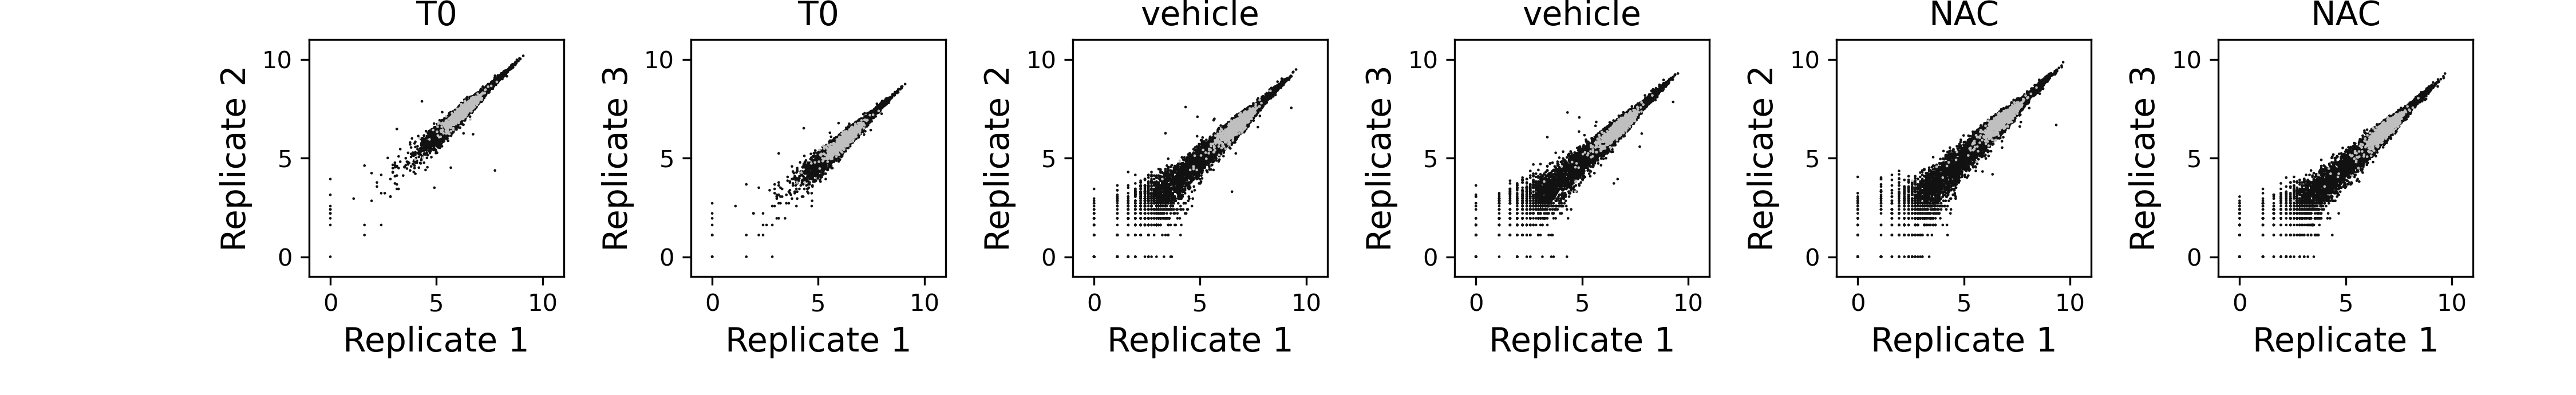

In [560]:
fig, axes = plt.subplots(ncols=6,
                         figsize=(15, 2.3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.9,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(screen.adata, 'TO_1_S1','TO_2_S2','T0', axes[0])
draw_scatter(screen.adata, 'TO_1_S1','TO_3_S3','T0', axes[1])

draw_scatter(screen.adata, 'TO_4_S4','TO_5_S5','vehicle', axes[2])
draw_scatter(screen.adata, 'TO_4_S4','TO_6_S6','vehicle', axes[3])

draw_scatter(screen.adata, 'TO_7_S7','TO_8_S8','NAC', axes[4])
draw_scatter(screen.adata, 'TO_7_S7','TO_9_S9','NAC', axes[5])

plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

In [561]:
# screen('results/adata_counts.h5ad.gz')

In [562]:
# adata.var.index = adata.var.target

# adata.var_names_make_unique()

In [563]:
# adata.obs['group'] = adata.obs[['cell line','timepoint','treatment']].apply(' '.join,axis=1)

In [564]:
# ax = sc.pl.violin(adata, ["PRDX2","PRDX3","PRDX4","PRDX5","PRDX6"],
#              layer='log2(x+1)', 
#              groupby='group',rotation=90,size=4,
#                  )

# 
- https://chat.openai.com/share/a37004eb-50bb-491f-be7c-ce4832ec6ce3
- https://chat.openai.com/share/04047284-5811-45bf-acc4-2012c49da931

In [659]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_threshold(x, threshold, pseudo_sd):
    return threshold * pseudo_sd * (1 if x > 0 else -1) / abs(x)

def prep_data(df_in,threshold=6):
    df = df_in.copy()

    df = scp.phenoScore.ann_score_df(df,threshold=threshold)

    pseudo_sd = df.loc[df['target'] == 'non-targeting', 'score'].std()

    df['-log10(pvalue)'] = np.log10(df.pvalue) * -1

    return df

def plot_volcano(ax, df_in, threshold=6, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6):

    df = prep_data(df_in,threshold)
    
    # Scatter plot for each category
    ax.scatter(df.loc[df['label'] == 'target_non_hit', 'score'], df.loc[df['label'] == 'target_non_hit', '-log10(pvalue)'],
               alpha=0.1, s=1, c='black', label='target_non_hit')
    ax.scatter(df.loc[df['label'] == up_hit, 'score'], df.loc[df['label'] == up_hit, '-log10(pvalue)'],
               alpha=0.9, s=1, c='#fcae91', label=up_hit)
    ax.scatter(df.loc[df['label'] == down_hit, 'score'], df.loc[df['label'] == down_hit, '-log10(pvalue)'],
               alpha=0.9, s=1, c='#bdd7e7', label=down_hit)
    ax.scatter(df.loc[df['label'] == 'non-targeting', 'score'], df.loc[df['label'] == 'non-targeting', '-log10(pvalue)'],
               alpha=0.1, s=1, c='gray', label='non-targeting')

    # Set x-axis and y-axis labels
    ax.set_xlabel('phenotype score')
    ax.set_ylabel('-log10(p-value)')

    # Set x-axis limits
    ax.set_xlim(xlim_l, xlim_r)

    # Set y-axis limits
    ax.set_ylim(0.1, ylim)

    # Add legend
    ax.legend()

def label_as_black(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=.5, t_y=-0.1):
    
    df = prep_data(df_in,threshold)
    
    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='black', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)

def label_sensitivity_hit(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=-.5, t_y=-0.1):
    
    df = prep_data(df_in,threshold)
    
    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='#3182bd', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)

def label_resistance_hit(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=.5, t_y=-0.1):

    df = prep_data(df_in,threshold)

    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='#de2d26', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)


In [660]:
# import pandas as pd
# from plotnine import ggplot, aes, geom_point, geom_text, xlab, theme, theme_classic, xlim, scale_y_continuous, ylab, stat_function


# def draw_threshold(x, threshold, pseudo_sd):
#     return threshold * pseudo_sd * (1 if x > 0 else -1) / abs(x)


# def plot_volcano(df_in, threshold=6, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6):
#     df = df_in.copy()
    
#     df = scp.phenoScore.ann_score_df(df,threshold=threshold)
    
#     pseudo_sd = df.loc[df['target'] == 'non-targeting', 'score'].std()
#     df['-log10(pvalue)'] = np.log10(df.pvalue) * -1

#     p = (
#         ggplot(df.dropna(), aes(x='score', y='-log10(pvalue)')) +
#         geom_point(data=df[df['label'] == 'target_non_hit'], alpha=.1,size=1, color=almost_black) +
#         geom_point(data=df[df['label'] == up_hit], alpha=.9,size=1, color='#fcae91') +
#         geom_point(data=df[df['label'] == down_hit], alpha=.9,size=1, color='#bdd7e7') +
#         geom_point(data=df[df['label'] == 'non-targeting'], alpha=.1,size=1, color='gray') +
#         xlab('phenotype score') +
#         theme_classic() +
#         xlim(xlim_l, xlim_r) +
#         scale_y_continuous(limits=(0.1, ylim)) +
#         ylab('-log10(p-value)') +
#         theme(figure_size=(3, 3))  # here you define the plot size
#     )

#     return p


# def label_as_black(p, label, size=2, t_x=5, t_y=-0.1):
#     print(p.data.query(f'target=="{label}"'))
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, colour="black", fill="black") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )


# def label_sensitivity_hit(p, label, size=2, t_x=-5, t_y=-0.1):
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, fill="#3182bd") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )


# def label_resistance_hit(p, label, size=2, t_x=5, t_y=-0.1):
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, fill="#de2d26") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )

### gamma

In [661]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

In [662]:
rho = screen.phenotypes['compare_reps']['rho:NAC_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

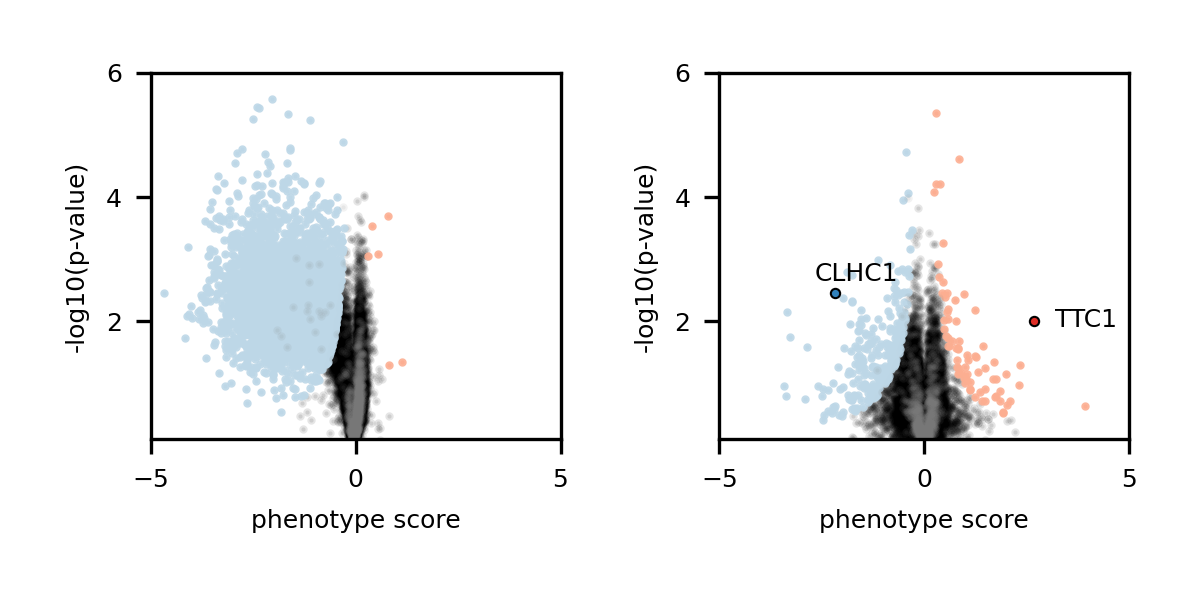

In [678]:
# Create subplots and specify the size
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 2))

plot_volcano(ax1, gamma,threshold=5)
ax1.grid(False)
ax1.get_legend().remove()

plot_volcano(ax2, rho,threshold=5)
label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6)
label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.2)


ax2.grid(False)
ax2.get_legend().remove()

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

plt.tight_layout()
# Show the plot
plt.show()

In [679]:
# vol.save('NAC_rho_score.pdf')

# 

In [684]:
%reload_ext watermark

In [ ]:
%watermark

Last updated: 2023-11-11T15:45:10.099320-08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [ ]:
%watermark --iversions

pandas    : 2.0.3
anndata   : 0.9.1
numpy     : 1.24.4
matplotlib: 3.7.2
screenpro : 0.2.3
scanpy    : 1.9.3



In [681]:
!date

Sat Nov 11 15:44:51 PST 2023
